In [35]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#### Load dataset

In [36]:
# create dataframe from file
df = pd.read_csv("university_data.csv")
print(df.shape)
df.head()

(1326, 7)


,Name,Applicants total,Enrolled total,Tuition and fees,Costs of living on campus,Ranking,Ranking display
0,Alabama A & M University,6142.0,1104.0,7182.0,27441.0,1000+,1000+
1,University of Alabama at Birmingham,5689.0,1773.0,7206.0,31687.0,301-400,top 1000
2,University of Alabama in Huntsville,2054.0,651.0,9192.0,35780.0,1000+,1000+
3,Alabama State University,10245.0,1479.0,8720.0,25222.0,1000+,1000+
4,The University of Alabama,30975.0,6454.0,9450.0,41500.0,1000+,1000+


#### Add Enrolled [%]

In [37]:
# Add % split of enrolled/applicants
df["Enrolled percentage"] = round(df["Enrolled total"] / df["Applicants total"] * 100, 2)
df = df.drop(columns=['Enrolled total', 'Applicants total'])
enrolledPercentageColumn = df.pop('Enrolled percentage')
df.insert(1, 'Enrolled percentage', enrolledPercentageColumn)
df.head()

,Name,Enrolled percentage,Tuition and fees,Costs of living on campus,Ranking,Ranking display
0,Alabama A & M University,17.97,7182.0,27441.0,1000+,1000+
1,University of Alabama at Birmingham,31.17,7206.0,31687.0,301-400,top 1000
2,University of Alabama in Huntsville,31.69,9192.0,35780.0,1000+,1000+
3,Alabama State University,14.44,8720.0,25222.0,1000+,1000+
4,The University of Alabama,20.84,9450.0,41500.0,1000+,1000+


In [38]:
def modifyRanking(ranking):
    if '-' in ranking:
        ranking = (int(ranking.split('-')[0]) + int(ranking.split('-')[1])) // 2
    elif '+' in ranking:
        ranking = ranking[:len(ranking)-1]
    return ranking

### Correlation Matrix for top 1500 universities

In [39]:
topUniDf = df[df['Ranking display'] == 'top 1000'].drop(columns=['Name', 'Ranking display'])
topUniDf['Ranking'] = df.apply(lambda row: modifyRanking(row['Ranking']), axis=1)
topUniDf['Ranking'] = pd.to_numeric(topUniDf['Ranking'])

corrMatrixTopUni = topUniDf.corr(method='pearson')
corrMatrixTopUni.style.background_gradient(cmap='coolwarm')

,Enrolled percentage,Tuition and fees,Costs of living on campus,Ranking
Enrolled percentage,1.000000,-0.736428,-0.789096,0.397754
Tuition and fees,-0.736428,1.000000,0.929673,-0.313554
Costs of living on campus,-0.789096,0.929673,1.000000,-0.413275
Ranking,0.397754,-0.313554,-0.413275,1.000000


### Correlation Matrix for universities ranked 1500+

In [40]:
nonTopUniDf = df[df['Ranking display'] == '1000+'].drop(columns=['Name', 'Ranking', 'Ranking display'])

corrMatrixNonTopUni = nonTopUniDf.corr(method='pearson')
corrMatrixNonTopUni.style.background_gradient(cmap='coolwarm')

,Enrolled percentage,Tuition and fees,Costs of living on campus
Enrolled percentage,1.000000,-0.453411,-0.483999
Tuition and fees,-0.453411,1.000000,0.862112
Costs of living on campus,-0.483999,0.862112,1.000000


### Correlation Matrix for all universities

In [41]:
allUniWithRankDf = df.drop(columns=['Name','Ranking display'])

allUniWithRankDf['Ranking'] = df.apply(lambda row: modifyRanking(row['Ranking']), axis=1)
allUniWithRankDf['Ranking'] = pd.to_numeric(allUniWithRankDf['Ranking'])

corrMatrixAllUniWithRank = allUniWithRankDf.corr(method='pearson')
corrMatrixAllUniWithRank.style.background_gradient(cmap='coolwarm')

,Enrolled percentage,Tuition and fees,Costs of living on campus,Ranking
Enrolled percentage,1.000000,-0.483321,-0.514040,0.106312
Tuition and fees,-0.483321,1.000000,0.855954,-0.071206
Costs of living on campus,-0.514040,0.855954,1.000000,-0.234522
Ranking,0.106312,-0.071206,-0.234522,1.000000


#### Outlier detection

In [42]:
anomalyDetectionDf = df.drop(columns=['Name', 'Ranking', 'Ranking display'])
print(anomalyDetectionDf.shape)
scaler = MinMaxScaler()
normalizedData = scaler.fit_transform(anomalyDetectionDf)
normalizedData

(1326, 3)


array([[0.18488461, 0.07357357, 0.29936555],
       [0.35226985, 0.07410352, 0.37859675],
       [0.35886381, 0.11795619, 0.45497294],
       ...,
       [0.18006594, 0.04349938, 0.36738197],
       [0.01014456, 0.60612083, 0.69637992],
       [0.1648491 , 0.44983219, 0.50763202]])

n_neighbors = 8


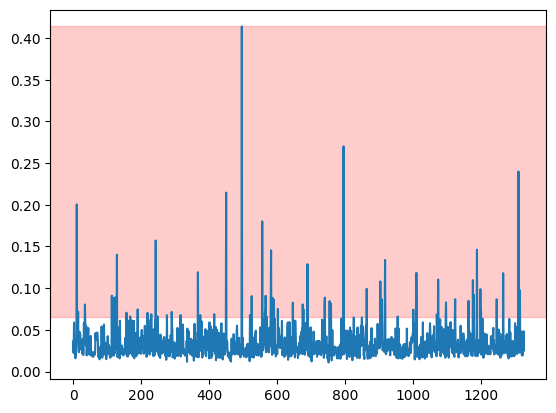

In [43]:
threshold = 0.065
n_neighbors = math.ceil(math.log(anomalyDetectionDf.shape[0]))

print(f'n_neighbors = {n_neighbors}')

neigh = NearestNeighbors(n_neighbors=n_neighbors)
neigh.fit(normalizedData)

distances, indices = neigh.kneighbors(normalizedData)
anomalyDetectionDf['distance'] = distances.mean(axis=1)
anomalyDetectionDf.head()

ax = plt.subplot()
ax.plot(anomalyDetectionDf['distance'])
ax.axhspan(threshold, max(anomalyDetectionDf['distance']), alpha=0.2, color='red')

In [44]:
outliersDf = anomalyDetectionDf[anomalyDetectionDf['distance'] > threshold]
outliersIndices = outliersDf.index.tolist() # powinno wyjść ok. 1% (13) / 5% (66) / 10% (130)
df['Outlier'] = False
df.loc[outliersIndices, 'Outlier'] = True
df[df['Outlier'] == True]['Ranking'].value_counts()

Ranking
1000+      63
701-800     2
37          1
401-500     1
501-600     1
Name: count, dtype: int64

In [45]:
# Correlation Matrix for outliers

outliersForCmDf = df[df['Outlier'] == True].drop(columns=['Name', 'Ranking', 'Ranking display', 'Outlier'])
corrMatrixOutliers = outliersForCmDf.corr(method='pearson')
corrMatrixOutliers.style.background_gradient(cmap='coolwarm')

,Enrolled percentage,Tuition and fees,Costs of living on campus
Enrolled percentage,1.000000,0.009891,-0.191353
Tuition and fees,0.009891,1.000000,0.781297
Costs of living on campus,-0.191353,0.781297,1.000000


In [46]:
# Correlation Matrix for non outliers

nonOutliersForCmDf = df[df['Outlier'] == False].drop(columns=['Name', 'Ranking', 'Ranking display', 'Outlier'])
corrMatrixNonOutliers = nonOutliersForCmDf.corr(method='pearson')
corrMatrixNonOutliers.style.background_gradient(cmap='coolwarm')

,Enrolled percentage,Tuition and fees,Costs of living on campus
Enrolled percentage,1.000000,-0.549453,-0.559922
Tuition and fees,-0.549453,1.000000,0.863193
Costs of living on campus,-0.559922,0.863193,1.000000


In [47]:
dfAll = df.copy() # All universities
df = df[df['Outlier'] == False].drop(columns=['Outlier']) # Universities without outliers
df.head()

,Name,Enrolled percentage,Tuition and fees,Costs of living on campus,Ranking,Ranking display
0,Alabama A & M University,17.97,7182.0,27441.0,1000+,1000+
1,University of Alabama at Birmingham,31.17,7206.0,31687.0,301-400,top 1000
2,University of Alabama in Huntsville,31.69,9192.0,35780.0,1000+,1000+
3,Alabama State University,14.44,8720.0,25222.0,1000+,1000+
4,The University of Alabama,20.84,9450.0,41500.0,1000+,1000+


#### Clustering

In [48]:
clusteringDf = df.drop(columns=['Name', 'Ranking', 'Ranking display'])
clusteringDf.head()

,Enrolled percentage,Tuition and fees,Costs of living on campus
0,17.97,7182.0,27441.0
1,31.17,7206.0,31687.0
2,31.69,9192.0,35780.0
3,14.44,8720.0,25222.0
4,20.84,9450.0,41500.0


In [49]:
scaler = MinMaxScaler()
normalizedData = scaler.fit_transform(clusteringDf)
clusteringDf = pd.DataFrame(normalizedData, columns=clusteringDf.columns)
clusteringDf.head()

,Enrolled percentage,Tuition and fees,Costs of living on campus
0,0.281576,0.063064,0.209404
1,0.536501,0.063600,0.298808
2,0.546543,0.107950,0.384991
3,0.213403,0.097410,0.162680
4,0.337003,0.113711,0.505432


In [50]:
kmeans = KMeans(n_clusters=3)
df['Cluster'] = kmeans.fit_predict(clusteringDf)

c:\Users\michu\source\repos\american-universities-eda\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


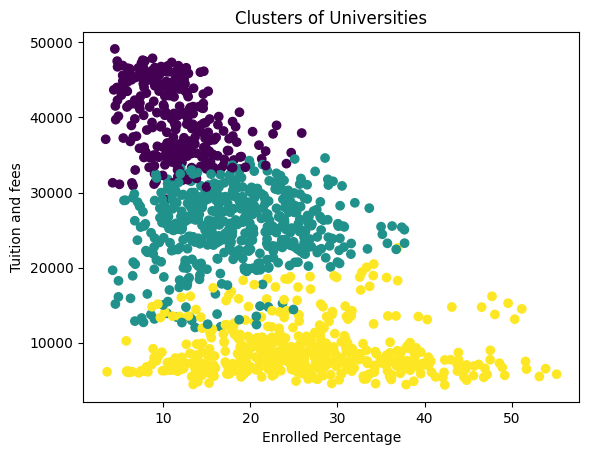

In [51]:
plt.scatter(df['Enrolled percentage'], df['Tuition and fees'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Enrolled Percentage')
plt.ylabel('Tuition and fees')
plt.title('Clusters of Universities')
plt.show()

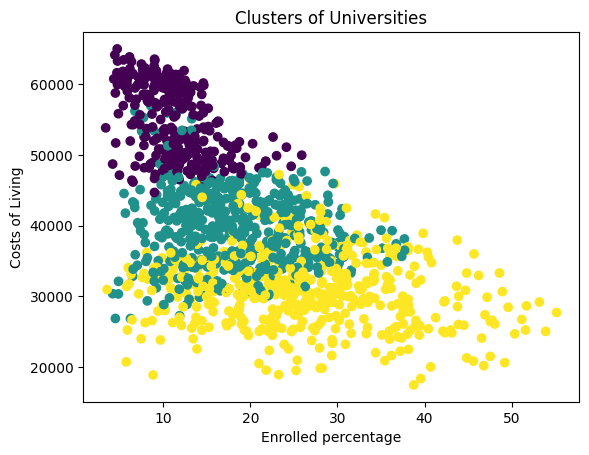

In [52]:
plt.scatter(df['Enrolled percentage'], df['Costs of living on campus'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Enrolled percentage')
plt.ylabel('Costs of Living')
plt.title('Clusters of Universities')
plt.show()

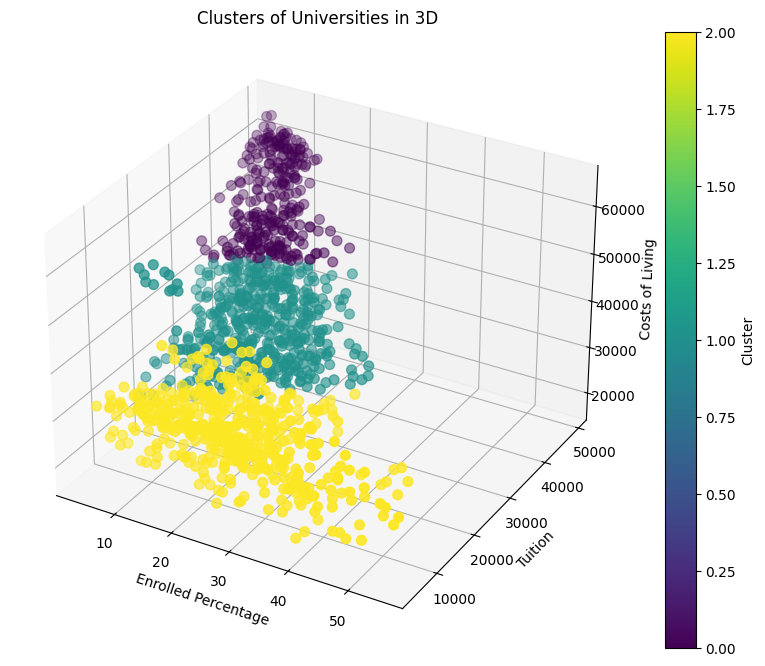

In [53]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Enrolled percentage'],
    df['Tuition and fees'],
    df['Costs of living on campus'],
    c=df['Cluster'],
    cmap='viridis',
    s=50
)

ax.set_xlabel('Enrolled Percentage')
ax.set_ylabel('Tuition')
ax.set_zlabel('Costs of Living')
ax.set_title('Clusters of Universities in 3D')

colorbar = fig.colorbar(scatter, ax=ax)
colorbar.set_label('Cluster')

plt.show()